In [90]:
import numpy as np
import scipy
from numpy import pi, sqrt, cos, sin, exp, real, imag
import matplotlib.pyplot as plt


In [91]:
A = 0.72
H = 7.12 
L = 8e3

r = 0.3

a_r = 0.1
dL = 0

g = 9.81
sigma = 1.4e-4

epsilon = A / H
eta = sigma * L / sqrt(g * H)
U = epsilon * sigma * L
kappa = g * H / (sigma * L) ** 2

In [92]:
x_x = np.linspace(0, 1+dL, 1000)

factor = 1
h_fx = lambda x: factor * x
h_fx_dx = lambda x: factor
h_fx_dxx = lambda x: 0

In [93]:
# complex system of equations:

def deriv(x_x, y_x):
    h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

    # helper functions that often appear
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
    s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

    # leading order
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
    Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

    u_x, u_x_dx = y_x

    dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

    # dz_x_dx2 = 1j * (Y0_x_dxx * u_x + Y0_x_dx * u_x_dx + Y0_x_dx + u_x_dx + Y0_x * u_x_dxx) / eta0_x - 1j / eta0_x**2 * eta0_x_dx * (Y0_x_dx * u_x + Y0_x * u_x_dx) 
    dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)
    

    u_x_dxx = -1j * (
        eta0_x_dx * dz_x / Y0_x +
        eta0_x * dz_x_dx / Y0_x +
        - eta0_x * dz_x * Y0_x_dx / Y0_x**2
    ) - (
        Y0_x_dxx * u_x / Y0_x + 
        Y0_x_dx * u_x_dx / Y0_x +
        - Y0_x_dx * u_x * Y0_x_dx / Y0_x**2
    )

    return [u_x_dx, u_x_dxx]




In [95]:
from scipy.integrate import solve_ivp
from scipy.optimize import root


def ivp(u_start, dense_output=False):
    x_range = [0, 1]


    u_start = u_start[0] + 1j * u_start[1]
    dz_start = 1 + 0j

    h_x, h_x_dx, h_x_dxx = h_fx(0), h_fx_dx(0), h_fx_dxx(0)
    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x
    eta0_x = 0.5 * (1 + s1_x)
    eta0_x_dx = 0.5 * s1_x_dx
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx


    # u_dx_start = (- eta0_x * 1j * dz_start - Y0_x_dx * u_start ) / Y0_x

    u_dx_start = (-1j * eta0_x * dz_start - u_start * Y0_x_dx)  / Y0_x


    y0 = np.array([u_start, u_dx_start])
    sol = solve_ivp(deriv, x_range, y0, dense_output=dense_output, rtol=1e-7)

    return sol


def mismatch(s):
    # velocity should be zero
    sol = ivp(s)
    
    return [real(sol.y[0, -1]), imag(sol.y[0, -1])]


s_guess = [0.1, 0.1]
res = root(mismatch, s_guess)

print(res)

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.900e-16 -5.579e-15]
       x: [ 4.878e-03  9.944e-01]
  method: hybr
    nfev: 8
    fjac: [[-9.998e-01 -1.879e-02]
           [ 1.879e-02 -9.998e-01]]
       r: [-6.972e+01  3.450e-05 -6.972e+01]
     qtf: [-1.395e-11  4.073e-11]


  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  4.068e-02 ...  9.966e-01  1.000e+00]
        y: [[ 4.87772952e-03+9.94447321e-01j
              5.07979186e-03+9.94196502e-01j ...
              2.11312201e-03+1.12563899e-01j
             -1.89952221e-16-5.57887070e-15j]
            [ 4.87772952e-03-5.55267904e-03j
              5.05948992e-03-6.80558995e-03j ...
             -5.74331236e-01-3.06751766e+01j
             -6.77449806e-01-3.60413142e+01j]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x00000253B80F95A0>
 t_events: None
 y_events: None
     nfev: 284
     njev: 0
      nlu: 0


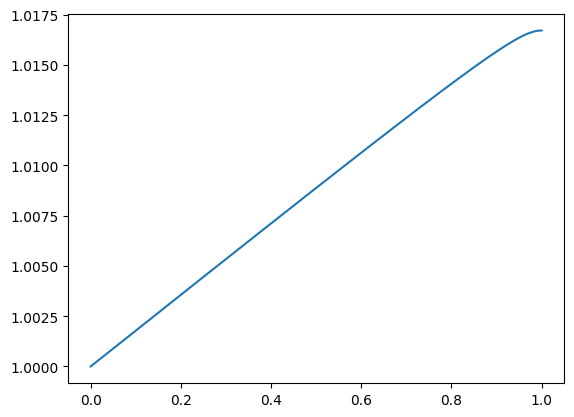

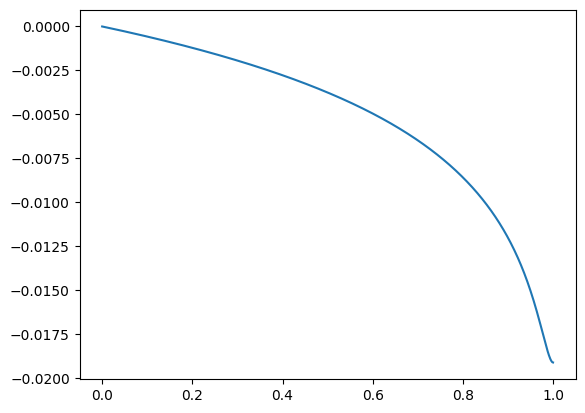

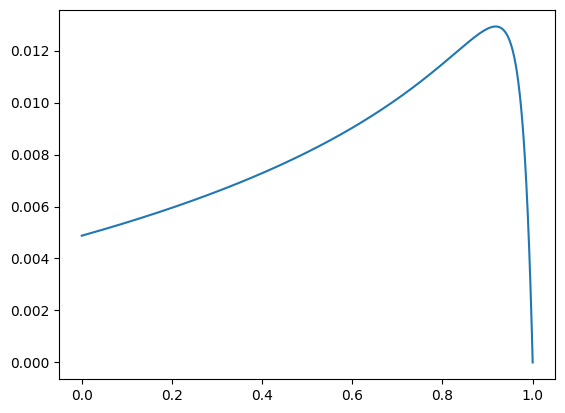

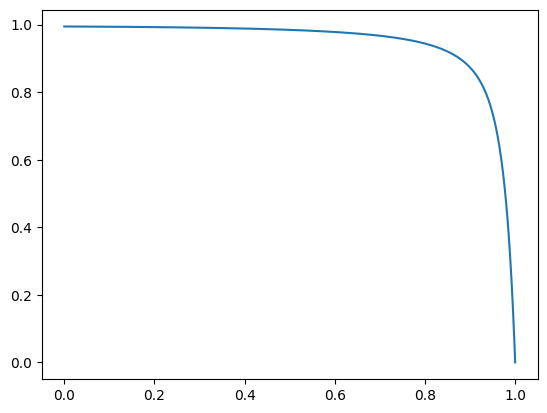

In [97]:

sol = ivp(res.x, True)
print(sol)


x_x = np.linspace(0, 1, 1000)
u_x, u_x_dx = sol.sol(x_x)

h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)
s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x
eta0_x = 0.5 * (1 + s1_x)
eta0_x_dx = 0.5 * s1_x_dx
Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx

dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x


uc_x, us_x = real(u_x), imag(u_x)
dzc_x, dzs_x = real(dz_x), imag(dz_x)



plt.plot(x_x, dzc_x)
plt.show()
plt.plot(x_x, dzs_x)
plt.show()

plt.plot(x_x, uc_x)
plt.show()
plt.plot(x_x, us_x)
plt.show()

In [ ]:


def deriv(x_x, y_x):
    dz0c_x, dz0s_x, u0c_x, u0s_x = y_x
    h_x, h_x_dx = h_fx(x_x), h_fx_dx(x_x)

    s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
    s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
    s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
    s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

    eta0_x = 0.5 * (1 + s1_x)
    Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
    Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx

    dz0c_x_dx = 1 / kappa * (- r / Y0_x * u0c_x - u0s_x)
    dz0s_x_dx = 1 / kappa * (- r / Y0_x * u0s_x + u0c_x)
    u0c_x_dx = (-eta0_x * dz0s_x - u0c_x * Y0_x_dx)  / Y0_x
    u0s_x_dx = ( eta0_x * dz0c_x - u0s_x * Y0_x_dx)  / Y0_x


    u_x = u0c_x - 1j * u0s_x 
    dz_x = dz0c_x - 1j * dz0s_x

    u_x_dx = (-1j * eta0_x * dz_x - u_x * Y0_x_dx)  / Y0_x


    # as a test
    def deriv(x_x, y_x):
        h_x, h_x_dx, h_x_dxx = h_fx(x_x), h_fx_dx(x_x), h_fx_dxx(x_x)

        # helper functions that often appear
        s1_x = scipy.special.erf(2 * (1 - h_x) / a_r)
        s2_x = exp(-4 * (1-h_x)**2 / a_r**2)
        s1_x_dx = h_x_dx * (-4) / pi**0.5 / a_r * s2_x
        s2_x_dx = h_x_dx * 8 * (1-h_x) / a_r**2 * s2_x

        s1_x_dxx = -4 / pi**0.5 / a_r * (h_x_dxx * s2_x + h_x_dx * s2_x_dx)
        s2_x_dxx = 8 / a_r**2 * (h_x_dxx * (1-h_x) * s2_x - h_x_dx  * h_x_dx * s2_x + h_x_dx * (1-h_x) * s2_x_dx)

        # leading order
        eta0_x = 0.5 * (1 + s1_x)
        eta0_x_dx = 0.5 * s1_x_dx
        Y0_x  = eta0_x * (1 - h_x) + a_r / 4 / pi**0.5 * s2_x
        Y0_x_dx = 0.5 * (s1_x_dx * (1 - h_x) - (s1_x + 1) * h_x_dx) + a_r / 4 / pi**0.5 * s2_x_dx
        Y0_x_dxx = 0.5 * (s1_x_dxx * (1 - h_x) - s1_x_dx * h_x_dx - s1_x_dx * h_x_dx - (s1_x + 1) * h_x_dxx) + a_r / 4 / pi**0.5 * s2_x_dxx

        u_x, u_x_dx = y_x

        dz_x = 1j * (Y0_x_dx * u_x + Y0_x * u_x_dx) / eta0_x

        # dz_x_dx2 = 1j * (Y0_x_dxx * u_x + Y0_x_dx * u_x_dx + Y0_x_dx + u_x_dx + Y0_x * u_x_dxx) / eta0_x - 1j / eta0_x**2 * eta0_x_dx * (Y0_x_dx * u_x + Y0_x * u_x_dx) 
        dz_x_dx = 1 / kappa * (- r / Y0_x * u_x - 1j * u_x)

        print(dz_x_dx)
        

        u_x_dxx = -1j * (
            eta0_x_dx * dz_x / Y0_x +
            eta0_x * dz_x_dx / Y0_x +
            - eta0_x * dz_x * Y0_x_dx / Y0_x**2
        ) - (
            Y0_x_dxx * u_x / Y0_x + 
            Y0_x_dx * u_x_dx / Y0_x +
            - Y0_x_dx * u_x * Y0_x_dx / Y0_x**2
        )

        return [u_x_dx, u_x_dxx]
    
    a = np.array(deriv(x_x, [u_x, u_x_dx]))
    b = np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])


    print(a, b)

    
    # print([a_[100] for a_ in a])
    # print([b_[100] for b_ in b])

    # raise SystemError


    return np.array([dz0c_x_dx, dz0s_x_dx, u0c_x_dx, u0s_x_dx])





def ivp(u_start, dense_output=False):
    print(u_start)
    uc_start, us_start = u_start
    dzc_start, dzs_start = 1, 0

    x_range = [0, 1]

    y0 = np.array([dzc_start, dzs_start, uc_start, us_start])
    sol = solve_ivp(deriv, x_range, y0, dense_output=dense_output, rtol=1e-7)

    return sol


def mismatch(s):
    # velocity should be zero
    sol = ivp(s)
    
    return np.array([sol.y[2, -1], sol.y[3, -1]]) # error


s_guess = [0.1, 0.1]
res = root(mismatch, s_guess)

print(res)


[0.1 0.1]
(-0.0023346963085134403-0.001257144166122622j)
[0.1       -1.1j       0.19874286-2.1976653j] [-0.0023347   0.00125714  0.1         1.1       ]
(-0.0025099933008644296-0.0012174094423015006j)
[0.10168577-1.11864098j 0.20386884-2.25372769j] [-0.00250999  0.00121741  0.10168577  1.11864098]
(-0.002437373368519843-0.0012339784853759692j)
[0.10098413-1.11088238j 0.20172828-2.23031704j] [-0.00243737  0.00123398  0.10098413  1.11088238]
(-0.0024898447548247983-0.0012220469915620888j)
[0.10148549-1.11642429j 0.20325118-2.24696626j] [-0.00248984  0.00122205  0.10148549  1.11642429]
(-0.002753806556535119-0.001160855533280626j)
[0.10403726-1.14462829j 0.21107384-2.33247486j] [-0.00275381  0.00116086  0.10403726  1.14462829]
(-0.0028015300306597425-0.0011495959901026507j)
[0.10450156-1.1497584j  0.21250734-2.34813837j] [-2.80153003e-03  1.14959599e-03  1.04501561e-01  1.14975840e+00]
(-0.0028613671766158496-0.001135388874297606j)
[0.1050857 -1.15621268j 0.21431611-2.3679019j ] [-2.86136

[ 0.00487773 -0.99444723]
(0.017833198985818626-0.005445443901513484j)
[0.00487773-0.00555277j 0.00431002-0.02893874j] [0.0178332  0.00544544 0.00487773 0.00555277]
(0.017644987021411852-0.01757251242301777j)
[0.01463876-0.07109112j 0.03821363-0.52179232j] [0.01764499 0.01757251 0.01463876 0.07109112]
(0.017831768088873656-0.0054966359357334245j)
[0.00491848-0.00582636j 0.00438136-0.02976325j] [0.01783177 0.00549664 0.00491848 0.00582636]
(0.0178309949829348-0.0055225827767632265j)
[0.00493903-0.00596802j 0.00441754-0.03019118j] [0.01783099 0.00552258 0.00493903 0.00596802]
(0.017827017444895694-0.00565602966214435j)
[0.00504464-0.00670111j 0.0046058 -0.03244471j] [0.01782702 0.00565603 0.00504464 0.00670111]
(0.017826262312623613-0.0056804173346133024j)
[0.00506387-0.00683749j 0.00464048-0.03286944j] [0.01782626 0.00568042 0.00506387 0.00683749]
(0.01782531109723674-0.005711198210775997j)
[0.00508813-0.00700985j 0.00468442-0.03340954j] [0.01782531 0.0057112  0.00508813 0.00700985]
(0.

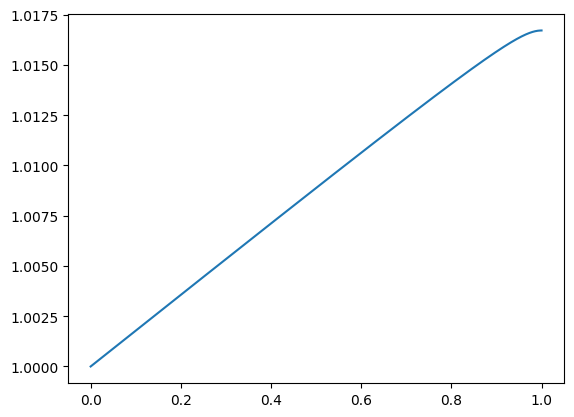

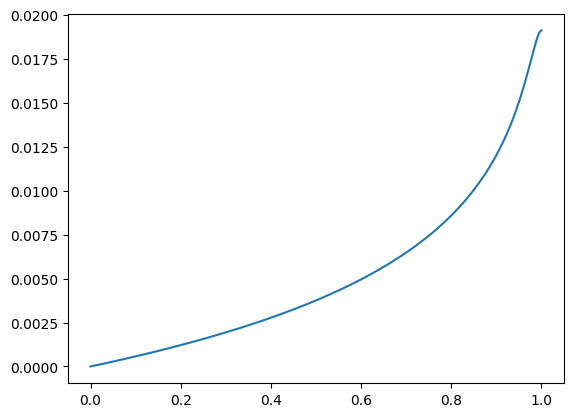

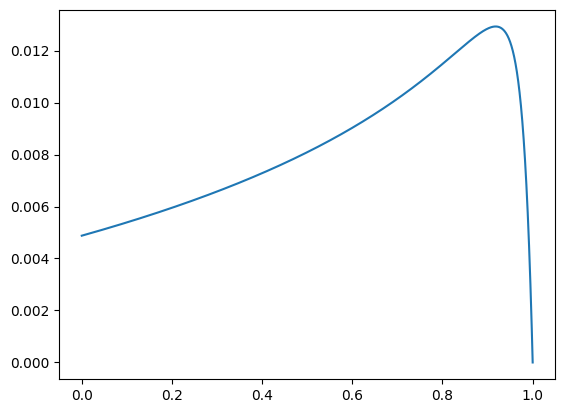

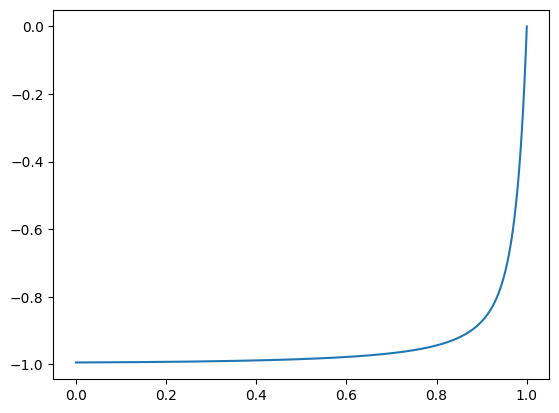

In [ ]:




sol = ivp(res.x, True)
print(sol)


x_x = np.linspace(0, 1, 1000)


dzc_x, dzs_x, uc_x, us_x = sol.sol(x_x)



plt.plot(x_x, dzc_x)
plt.show()
plt.plot(x_x, dzs_x)
plt.show()

plt.plot(x_x, uc_x)
plt.show()
plt.plot(x_x, us_x)
plt.show()